## Installs

### Instructions 
- **Google CoLab:** If you are running this notebook on a sandbox environmemt like Google CoLab, use the following code blocks to install the packages required to run this notebook. Remember that once your session is disconected, you will have to install the packages again. 
- **Local**: If you are running this notebook on your local laptop, we recommed that you create a virtual environemnt and install the packages listed in `requirements.txt`. Make sure that your Python interpreter, when running the notebook, it is properly set to the virtual environment you created. The following commands can help you set-up the virtual environment and install the packages. 
```
    $ python -m venv venv
    $ source venv/bin/activate  # Activate virtual environment for MAC/UNIX
    $ venv\Scripts\activate # Activate virtual environment for WINDOWS
    $ pip install -r requirements.txt
```

In [ ]:
pip install earthengine-api

In [ ]:
pip install earthengine-api --upgrade

In [ ]:
pip install earthpy

In [ ]:
pip install geehydro

In [ ]:
!pip install geemap

### Imports and Library authentication

In [3]:
import ee
from datetime import datetime as dt

import earthpy as ep
from glob import glob
from os import path

import geemap
import geehydro
import pandas as pd
import numpy as np
import folium

import requests
import json
import urllib
from bs4 import BeautifulSoup

import earthpy.spatial as es

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import Image
from tqdm import tqdm

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


*** Earth Engine *** Please upgrade your Earth Engine Python client: authentication is changing! https://developers.google.com/earth-engine/guides/python_install


# Main code
## Model to extract NDVI data for US cities

In [5]:
class Landsat: 
  def __init__(self, name, short_name, start_date, end_date):
    """
    Model class to store store information about LANDSAT Collections. 
    """
    self.name = name
    self.short_name = short_name
    self.start_date = start_date
    self.end_date = end_date

LANDSAT_5 = Landsat("LANDSAT/LT05/C01/T1_8DAY_NDVI", "LANDSAT 5" ,"1984-01-01", "2012-04-30") # 36 years of data 
LANDSAT_7 = Landsat("LANDSAT/LE07/C01/T1_8DAY_NDVI", "LANDSAT 7" ,"1999-01-01", "2022-01-01") # 22 years of data
LANDSAT_8 = Landsat("LANDSAT/LC08/C01/T1_8DAY_NDVI", "LANDSAT 8" ,"2013-04-07", "2022-01-01") # 09 years of data

In [6]:
class UsNdviModel:
  def __init__(self, name, state, map_center=[0,0]):
    """
      name (str): The name of the city/county
      state (str): The 2-letter state code
      map_center (list): A list of lat and long coordinates to draw the map center
    """
    self.name = name
    self.state = state
    self.map_center = map_center
    self.queryBoundaries()
  
  ########################################################
  ## ------- City Boundaries & Map Visualizations --------
  def queryBoundaries(self, save_local=False):
    # Define API URL
    # Isabel's key a3cc23ee01msh377f4a68f061dffp119381jsn2b8bb1b299f1
    # d88dd62b02msh4be30997163aac2p14d9c1jsn61c18de35762
    url = "https://vanitysoft-boundaries-io-v1.p.rapidapi.com/reaperfire/rest/v1/public/boundary/place/{}/state/{}"\
          .format(urllib.parse.quote(self.name), self.state)

    headers = {
      'x-rapidapi-host': "vanitysoft-boundaries-io-v1.p.rapidapi.com",
      'x-rapidapi-key': "d88dd62b02msh4be30997163aac2p14d9c1jsn61c18de35762"
      }
      
    response = requests.request("GET", url, headers=headers)
    
    _json = json.loads(response.text)
    
    if save_local:
      # the json file where the output must be stored
      _filename = f"{self.name}-{self.state}.json"
      out_file = open(_filename, "w")
      json.dump(_json, out_file, indent = 3)
      out_file.close()

    self._boundaries = geemap.geojson_to_ee(_json)
    return self._boundaries    
  
  def drawMapWithBoundaries(self, zoom=12):
    """ 
      Input: 
        zoom (int): Optional argument for initial map zoom
      Output:
        Returns a Folium map centered at self.map_center
    """
    map = folium.Map(location=self.map_center, zoom_start=zoom)
    map.addLayer(self._boundaries)
    return map

  def visualizeNdvi(self, landsat_obj, start=None, end=None):
    """
    Display the 8-day NDVI obtained from a specific Landsat colection. 
    Please note: This method will display the first 8-day ndvi available for the range of dates provided. 
    Hence, you must change the pair of start and end dates to observe differnt images. 
    Input: 
    - landsat_obj (Landsat): Which landsat collection to extract data from
    - start/end (string): Dates to filter for ndvi images (yyyy-mm-dd)
    """
    landsat = ee.ImageCollection(landsat_obj.name)
    start_date = start if start != None else landsat_obj.start_date
    end_date = end if end != None else landsat_obj.end_date

    landsat_AOI = landsat.filterBounds(self._boundaries).\
                  filterDate(start_date,end_date)

    palette = [
      'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
      '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
      '012E01', '011D01', '011301']

    ndvi_parameters = {'min': 0,
                      'max': 1,
                      'dimensions': 512,
                      'palette': palette}

    print("Showing the 8-day average NDVI obtained on:", landsat_AOI.first().getInfo()['id'].split("/")[-1])
    map = self.drawMapWithBoundaries()
    map.addLayer(landsat_AOI.first().clip(self._boundaries), ndvi_parameters)
    return map
  
  #################################################
  # ------ NDVI Computations & Manipulation -------

  def singleLandsatHistoricalNdvi(self, landsat_obj:Landsat, start:str = "", end:str = "", show_logs=False):
    """
      Creates a pandas dataframe with the monthly avg ndvi for a specific Landsat
      Input:
      - landsat_obj (Landsat): Which landsat to extract data from
      - start (str, optional): Date to start filtering data. 
      - end (str, optional): Date to end filtering data. 
      * obs: if start or end is not provided, the default dates are the Landsat's
            date range 
      Outputs:
      - A pandas dataframe with the monthly ndvi
    """

    landsat = ee.ImageCollection(landsat_obj.name)
    start_date = start if start != "" else landsat_obj.start_date
    end_date = end if end != "" else landsat_obj.end_date

    if show_logs:
      print("Gathering NDVI from "+ landsat_obj.short_name + " from {} to {}"
          .format(start_date, end_date))

    start_year, end_year = int(start_date.split('-')[0]), int(end_date.split('-')[0])
    landsat_AOI = landsat.filterBounds(self._boundaries).filterDate(start_date,end_date)

    
    global COLLECTION, BOUNDARIES, MONTHS
    COLLECTION = landsat_AOI
    BOUNDARIES = self._boundaries
    
    MONTHS = ee.List.sequence(1,12)
    years = ee.List.sequence(start_year,end_year)

    output = years.map(yearFunc).getInfo()
    df = self.convertToDataFrame(output, landsat_obj.short_name)
    
    self.df = df
    return df


  def mergeLandsatData(self, show_logs=False):
    """
      Creates a pandas dataframe with the monthly avg ndvi for ALL Landsats
    """
    # Because there is a limit amount of data, we get Landsat data in batches
    # We use LANDSAT 5 and LANDSAT 7 to gather data from 1984 to 2022
    data_frames = []
    start_year, end_year = 1984, 2022
    curr_year = start_year
    yr_batch = 3

    while curr_year < end_year:
      landsat = LANDSAT_5 if curr_year < 1999 else LANDSAT_7 
      upper_bound = curr_year + yr_batch
      if upper_bound > end_year:
        upper_bound = end_year
      
      data_frames.append(self.singleLandsatHistoricalNdvi(landsat, f"{curr_year}-01-01", f"{upper_bound}-01-01", show_logs=show_logs))

      curr_year = upper_bound
      
    merged_df = pd.concat(data_frames)
    self.merged_df = merged_df.copy()
    return merged_df

  def saveDataFrameToCSV(self, filepath=""):
    if not hasattr(self, "merged_df"):
      self.mergeLandsatData()

    if filepath=="":
      filepath = '{}_{}.csv'.format(self.name, self.state)

    self.merged_df.to_csv(filepath, index=False)

  ################################
  #---------- PLOTS -----------

  def plotNdvi(self, figsize=(30,15)):
    """
    Plot time-series ndvi data from a single LANDSAT collection 
    """
    if not hasattr(self, "df"):
      raise Exception("You must run 'singleLandsatHistoricalNdvi' before executing this function")

    plt.figure(figsize=figsize)
    plt.plot(self.df["month-year"], self.df["NDVI"], '-o', label=self.df["landsat"][0])

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gcf().autofmt_xdate() # Rotation
    plt.legend()
    plt.show()
  
  def plotMergedNdvi(self, figsize=(20,12)):
    """
    Plot time-series NDVI from multiple LANDSAT collections
    """
    if not hasattr(self, "merged_df"):
      self.mergeLandsatData()
    
    _df = self.merged_df

    plt.figure(figsize=(20,12))
    landsats = list(np.unique(_df["landsat"]))
    for val in landsats:
      plt.plot(_df.loc[_df["landsat"]==val]["month-year"], _df.loc[_df["landsat"]==val]["NDVI"], label=val)

    year_avg = self.merged_df.groupby(pd.Grouper(key='month-year', freq='1Y')).mean()
    plt.plot(year_avg["NDVI"].keys(), year_avg["NDVI"].values, '-o', label="Yearly average")
    
    plt.legend()
    plt.show()


  ###############################
  #------- HELPER METHODS -------
  def convertToDataFrame(self, output, landsat_short_name):
    ndvi_list = []
    date_list = []

    for lst in output:
      for dic in lst:
        if "NDVI" in dic and dic["NDVI"] != None:
          ndvi_list.append(dic["NDVI"])
          date_list.append("{}-{}".format(dic["month"], dic["year"]))

    data = {"NDVI":ndvi_list, "month-year":date_list}
    df =  pd.DataFrame(data)
    df["month-year"] = pd.to_datetime(df["month-year"], format="%m-%Y")
    df["landsat"] = landsat_short_name

    return df

In [7]:
def yearFunc(_y):
  global y, MONTHS
  y=_y
  return MONTHS.map(monthFunc).flatten()

def monthFunc(m):
  global y, COLLECTION, BOUNDARIES
  return (COLLECTION
      .filter(ee.Filter.calendarRange(y,y,"year"))
      .filter(ee.Filter.calendarRange(m,m,'month'))
      .mean()
      .reduceRegion(ee.Reducer.mean(), BOUNDARIES, 30, maxPixels=30e9)
      .set('year', y)
      .set('month', m))

## Examples

### Seattle, WA

In [9]:
seattle = UsNdviModel("Seattle", "WA", [47.6062, -122.3321])

In [10]:
seattle.visualizeNdvi(LANDSAT_8, "2021-01-02", "2021-01-10")

Showing the 8-day average NDVI obtained on: 20210109


In [11]:
seattle.visualizeNdvi(LANDSAT_8, "2021-06-02", "2021-06-10")

Showing the 8-day average NDVI obtained on: 20210602


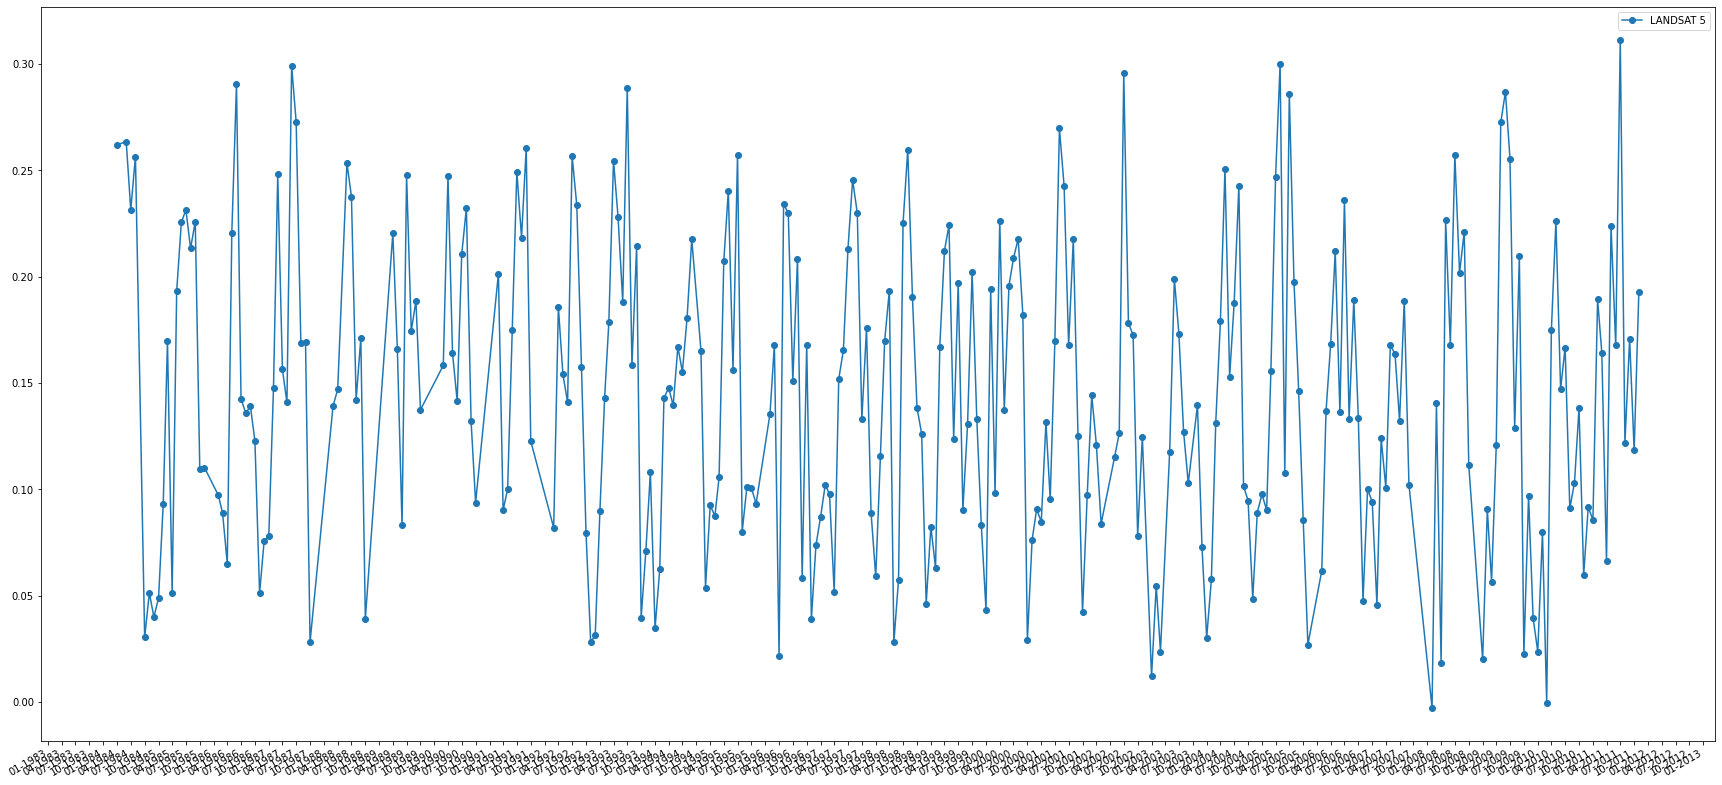

In [12]:
# Let's get all the observations for the Landsat 5 in Seattle
seattle_df = seattle.singleLandsatHistoricalNdvi(LANDSAT_5)
seattle.plotNdvi()

In [34]:
merged_df = seattle.mergeLandsatData()
merged_df

,NDVI,month-year,landsat
0,0.262032,1984-04-01,LANDSAT 5
1,0.263340,1984-06-01,LANDSAT 5
2,0.231436,1984-07-01,LANDSAT 5
3,0.256356,1984-08-01,LANDSAT 5
4,0.030448,1984-10-01,LANDSAT 5
...,...,...,...
18,0.206088,2021-07-01,LANDSAT 7
19,0.262852,2021-08-01,LANDSAT 7
20,0.036042,2021-10-01,LANDSAT 7
21,0.030224,2021-11-01,LANDSAT 7


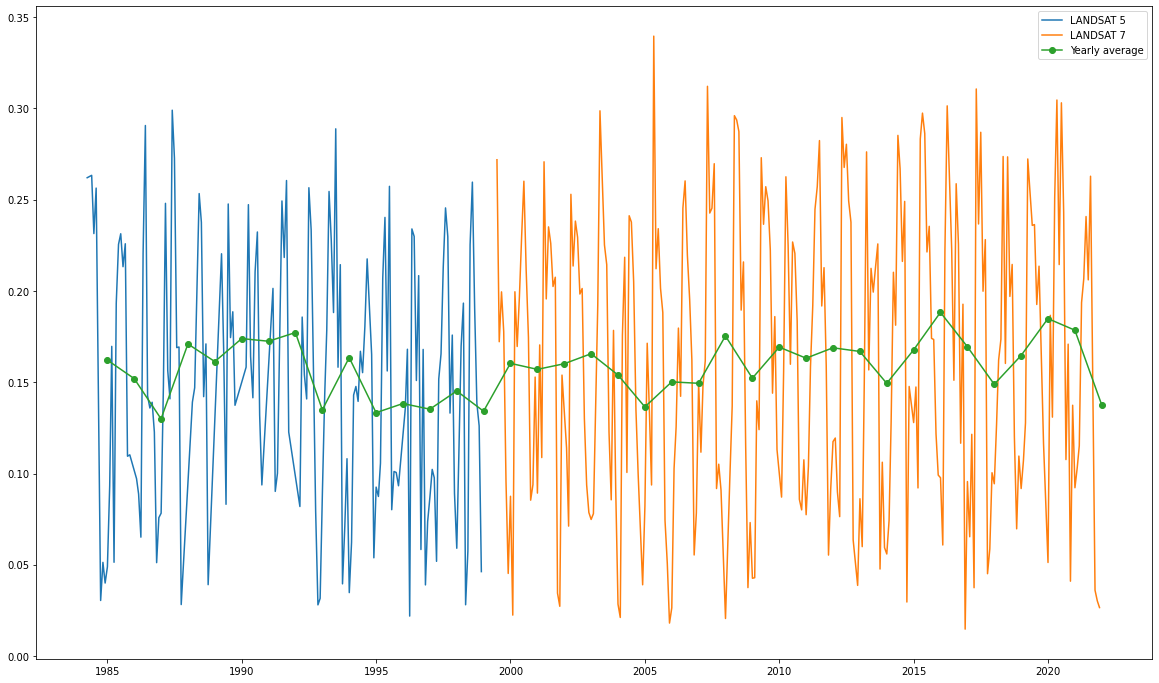

In [35]:
seattle.plotMergedNdvi()

### Houston, TX

In [14]:
houston = UsNdviModel("Houston", "TX", [29.759527, -95.355758])

In [15]:
# Visualize the plain map with the city boundaries
houston.drawMapWithBoundaries()

In [17]:
# Let's visualize the NDVI for a week in August
houston.visualizeNdvi(landsat_obj=LANDSAT_8, start="2021-08-02", end="2021-08-10")

Showing the 8-day average NDVI obtained on: 20210805


In [ ]:
df = houston.mergeLandsatData()

Gathering NDVI from LANDSAT 5 from 1984-01-01 to 1987-01-01
Gathering NDVI from LANDSAT 5 from 1987-01-01 to 1990-01-01
Gathering NDVI from LANDSAT 5 from 1990-01-01 to 1993-01-01
Gathering NDVI from LANDSAT 5 from 1993-01-01 to 1996-01-01
Gathering NDVI from LANDSAT 5 from 1996-01-01 to 1999-01-01
Gathering NDVI from LANDSAT 7 from 1999-01-01 to 2002-01-01
Gathering NDVI from LANDSAT 7 from 2002-01-01 to 2005-01-01
Gathering NDVI from LANDSAT 7 from 2005-01-01 to 2008-01-01
Gathering NDVI from LANDSAT 7 from 2008-01-01 to 2011-01-01
Gathering NDVI from LANDSAT 7 from 2011-01-01 to 2014-01-01
Gathering NDVI from LANDSAT 7 from 2014-01-01 to 2017-01-01
Gathering NDVI from LANDSAT 7 from 2017-01-01 to 2020-01-01
Gathering NDVI from LANDSAT 7 from 2020-01-01 to 2022-01-01


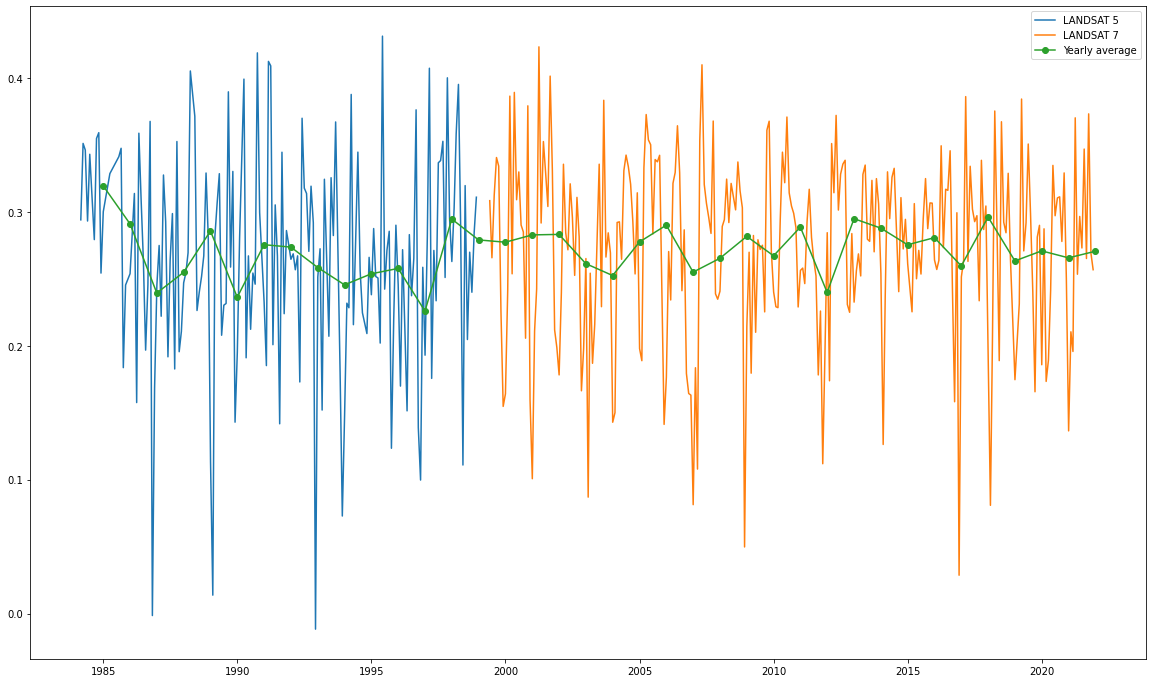

In [ ]:
houston.plotMergedNdvi()

### Indianopolis, IN

In [22]:
indianapolis = UsNdviModel("Indianapolis", "IN", [39.766734, -86.156744])

In [29]:
indianapolis.visualizeNdvi(LANDSAT_8, start="2021-03-10", end="2021-03-30")

Showing the 8-day average NDVI obtained on: 20210314


# Generate CSV Files
In this section, we use the model defined above to gather time-series NDVI using the Landsat Collections 5 and 7 from 1984-2022. 

## US State Capitals
Firstly, let's gather NDVI data from each US State Capital. The  `us-states-territories.csv` contains the state name, state 2-letter abbreviation, and capital for each of the 50 US states, in addition to information about other US Territories.

In [7]:
filepath = "../data/us-states-territories.csv"
with open(filepath, encoding="utf8", errors='ignore') as f:
    us_state_capitals = pd.read_csv(f, usecols=["Type", "Name", "Abbreviation","Capital"])

us_state_capitals.head()

,Type,Name,Abbreviation,Capital
0,State,Alabama,AL,Montgomery
1,State,Alaska,AK,Juneau
2,State,Arizona,AZ,Phoenix
3,State,Arkansas,AR,Little Rock
4,State,California,CA,Sacramento


In [8]:
# Let's pre-process the data, since we are not interested on US territories
us_state_capitals = us_state_capitals.loc[(us_state_capitals["Type"] == "State") | (us_state_capitals["Type"]== "Federal District")]

# Removing trailing and leading white spaces
us_state_capitals["Name"] = us_state_capitals['Name'].str.strip()
us_state_capitals["Abbreviation"] = us_state_capitals['Abbreviation'].str.strip()

In [9]:
class City:
  def __init__(self, city_name, state):
    self.city_name = city_name
    self.state = state

In [10]:
CITIES_TO_DOWNLOAD = []

for city, abbv in zip(us_state_capitals["Capital"].values, us_state_capitals["Abbreviation"].values):
    CITIES_TO_DOWNLOAD.append(City(city_name=city.strip(), state=abbv.strip()))

In [55]:
for city in tqdm(CITIES_TO_DOWNLOAD):
    temp_model = UsNdviModel(city.city_name, city.state)
    temp_model.mergeLandsatData()
    temp_model.saveDataFrameToCSV(filepath="../data/ndvi/{}-{}.csv".format(city.city_name, city.state))

100%|██████████| 15/15 [16:47<00:00, 67.16s/it]


## Most Populous US Cities
Next, we will gather NDVI data for the most populous us cities. 

### Scrap Most Populous US cities from Wikipedia
In these step, we will scrap this [Wikipedia page](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) containing the list of most ppulous cities in the US. 

In [11]:
url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
result = requests.get(url).text
doc = BeautifulSoup(result, "html.parser")
# Get the document body
body = doc.body

In [12]:
# Get the table containing the information we want
tbody = doc.find_all("tbody")[4]

# All cities and states are <a> tags, so let's extract those
a_tags = tbody.find_all("a")

In [13]:
raw_names = []

# Let's get the raw <a> tags
for idx, tag in enumerate(a_tags):
    if tag.getText()[0].isalpha():
        raw_names.append(tag.getText())

In [14]:
raw_names[:10]

['New York',
 'New York',
 'Los Angeles',
 'California',
 'Chicago',
 'Illinois',
 'Houston',
 'Texas',
 'Phoenix',
 'Arizona']

In [15]:
# Looking at the above output, we notice a pattern: city names are followed by state names. 
# Hence, we can simply split them with the following: 
cities = raw_names[::2]
states = raw_names[1::2]

In [16]:
# Finally, let's put those together on a DataFrame
populous_cities = pd.DataFrame({
    "Cities": cities,
    "States": states
})

populous_cities.head()

,Cities,States
0,New York,New York
1,Los Angeles,California
2,Chicago,Illinois
3,Houston,Texas
4,Phoenix,Arizona


### Match states with their abbreviations
In this step, we match the states from the cities we just scrapped with the state abbreviations in `us-state-territories.csv`. 

In [17]:
abbv = []
for state in states: 
    _abv = us_state_capitals.loc[us_state_capitals["Name"] == state,"Abbreviation"].iloc[0]
    abbv.append(_abv)

In [18]:
# Let's complete the DataFrame
populous_cities["Abbreviation"] = abbv
populous_cities.head()

,Cities,States,Abbreviation
0,New York,New York,NY
1,Los Angeles,California,CA
2,Chicago,Illinois,IL
3,Houston,Texas,TX
4,Phoenix,Arizona,AZ


In [19]:
# Export as csv for future usage
populous_cities.to_csv("../data/most-populous-us-cities")

### Generate `.csv` for times-series ndvi

In [24]:
CITIES_TO_DOWNLOAD = []

# How many cities to consider from the "most populous" dataset. Let's pick the Top 50. 
N = 50

# To avoid duplicates, let us check which of the csvs already exist.
for city, abbv in zip(populous_cities["Cities"].values[:N], populous_cities["Abbreviation"].values[:N]):
    _city = City(city_name=city, state=abbv)
    filepath="../data/ndvi/{}-{}.csv".format(_city.city_name, _city.state)

    if not path.exists(filepath):   
        CITIES_TO_DOWNLOAD.append(_city)

In [ ]:
for city in tqdm(CITIES_TO_DOWNLOAD):
    temp_model = UsNdviModel(city.city_name, city.state)
    temp_model.mergeLandsatData()
    temp_model.saveDataFrameToCSV(filepath="../data/ndvi/{}-{}.csv".format(city.city_name, city.state))